Documentation:
1. Converted class label to categorical
2. Supplied (original) vectorisers + TF-IDF vectorizer
3. Added preprocessing (punctuation removal, casefolding, stop-words removal (including words to short), lemmatization) steps to the text features
4. Encoded the simple string features ('Authors', 'Publisher', 'Language')
5. Dimensionality reduction with TruncatedSVD
6. Bigrams instead of words
7. Feature selection with SelectKBest
8. Standardization of 'pageNumbers' 
9. Instead of 8: Take the log of the standardized 'pageNumbers' using MinMaxScaler

Yet to try:
* Discretisation of PageNumbers

In [1]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
import scipy

In [2]:
# Load datasets
original_train_df = pd.read_csv(r"book_rating_train.csv", index_col = False, delimiter = ',', header=0)
original_test_df = pd.read_csv(r"book_rating_test.csv", index_col = False, delimiter = ',', header=0)
print("Training set size:", len(original_train_df))
print("Test set size:", len(original_test_df))

Training set size: 23063
Test set size: 5766


In [3]:
# Make a copy of the original datasets
train_df = original_train_df.copy()
test_df = original_test_df.copy()

In [4]:
# Encode authors, publisher, and language to numerical features (in both training and test set)
string_features = ['Authors', 'Publisher', 'Language']

for feature in string_features: 
    all_values = np.concatenate((train_df[feature], test_df[feature]))
    num, mapping = pd.factorize(all_values)
    numerical_feature_train = pd.Categorical(train_df[feature], mapping).codes
    numerical_feature_test = pd.Categorical(test_df[feature], mapping).codes
    train_df[feature] = numerical_feature_train
    test_df[feature] = numerical_feature_test

In [5]:
x_full_train = train_df.iloc[:,:-1]
x_full_test = test_df

In [6]:
y_full_train = train_df.iloc[:,-1]

# Data Visualisation

In [7]:
# Look at NMI of the numerical attributes

from sklearn.metrics.cluster import normalized_mutual_info_score

numerical_features = ['PublishYear', 'PublishMonth', 'PublishDay', 'pagesNumber', 'Authors', 'Publisher', 'Language']

for feature in numerical_features:
    print(f"NMI for {feature} =", normalized_mutual_info_score(x_full_train[feature], y_full_train))

NMI for PublishYear = 0.005010413368619569
NMI for PublishMonth = 0.0007191125502055215
NMI for PublishDay = 0.0013529681241697595
NMI for pagesNumber = 0.01964529722439041
NMI for Authors = 0.1252321628891643
NMI for Publisher = 0.05575051762580517
NMI for Language = 0.008829461322732114


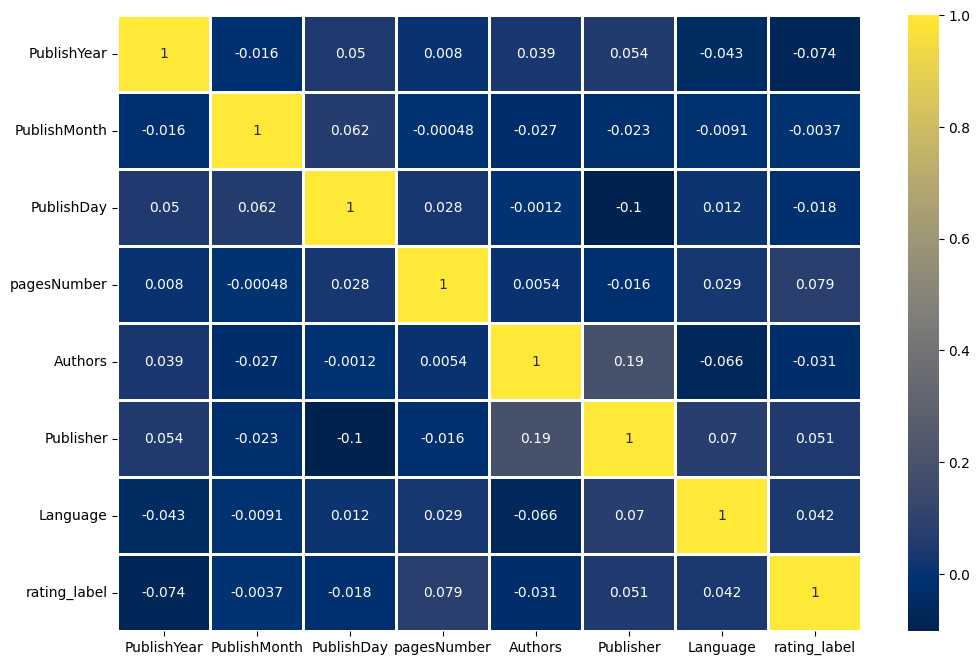

In [8]:
# Look at the correlation matrix of the numerical attributes
cor_matrix = train_df[numerical_features + ['rating_label']].corr()
round(cor_matrix, 2)
plt.figure(figsize=(12, 8))
sns.heatmap(cor_matrix, cmap='cividis', annot=True, linewidths=2)
plt.show()

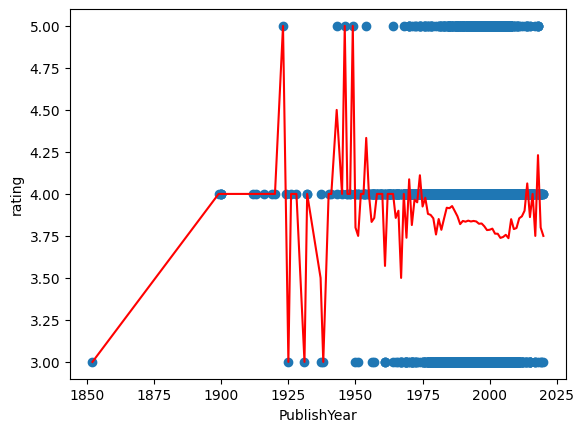

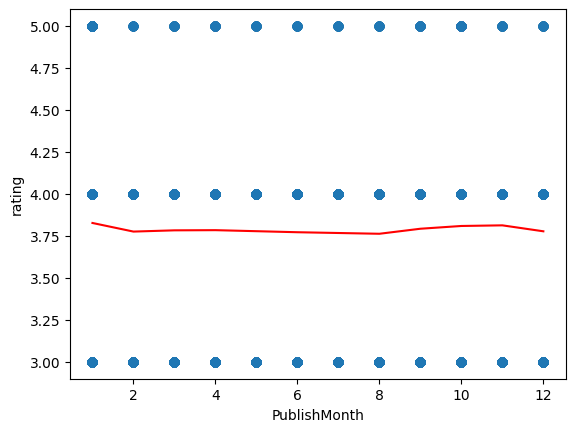

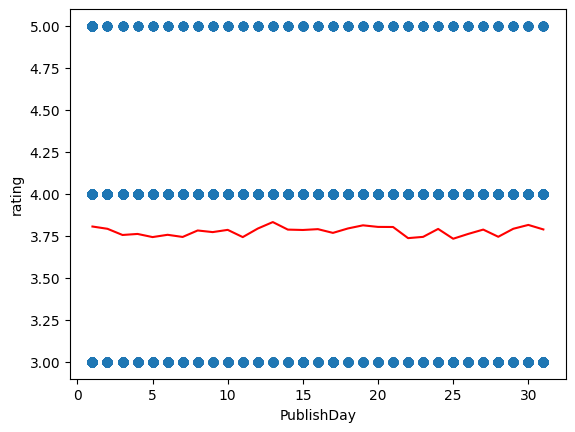

In [9]:
# Scatterplots for Publish year, month, and day vs. Rating
for feature in ['PublishYear', 'PublishMonth', 'PublishDay']: 
    plt.scatter(train_df[feature], train_df['rating_label'])
    plt.xlabel(feature)
    plt.ylabel('rating')

    values, counts = np.unique(sorted(train_df[feature]), return_counts=True)
    avg = []
    for i in range(len(values)): 
        v = values[i]
        c = counts[i]
        avg.append(sum(train_df.loc[train_df[feature] == v]['rating_label'])/c)
    plt.plot(values, avg, color = 'red')
    plt.show()

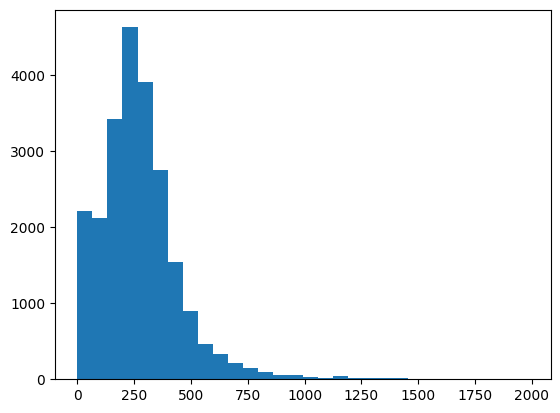

In [10]:
# Histogram for pages number < 2000
pageNum = train_df.loc[train_df['pagesNumber'] < 2000]['pagesNumber']
plt.hist(pageNum, bins = 30)
plt.show()

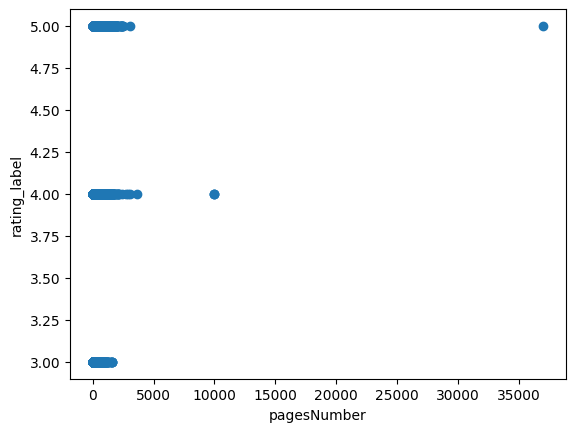

In [11]:
plt.scatter(train_df['pagesNumber'], train_df['rating_label'])
plt.xlabel('pagesNumber')
plt.ylabel('rating_label')
plt.show()

In [12]:
# Convert rating_label to categorical class label (need to do this after the visualisations)
train_df['rating_label'] = train_df['rating_label'].astype('category')
y_full_train = train_df['rating_label']

# Check class distributions
class_labels, count = np.unique(train_df['rating_label'], return_counts=True)
for pair in zip(class_labels, count):
    print(f"Rating {pair[0]}: {pair[1]} instances")

Rating 3.0: 5864 instances
Rating 4.0: 16208 instances
Rating 5.0: 991 instances


In [13]:
x_full_train = train_df.iloc[:,:-1]

In [14]:
# standardise page number (to be done after visualisations)
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import normalize
from sklearn.impute import SimpleImputer

scaler = MinMaxScaler()
x_full_train['pagesNumber'] = scaler.fit_transform(x_full_train['pagesNumber'].values.reshape(-1, 1))

# Check if imputation is needed for missing values (no)
print(f"The pagesNumber column has {x_full_train['pagesNumber'].isna().sum()} missing values.")
print(f"The pagesNumber column has {(x_full_train['pagesNumber'] == np.inf).sum()} infinite values.")
print(f"The pagesNumber column has {(x_full_train['pagesNumber'] == 0).sum()} zero values.")  # 196 zero values

# Take the log
x_full_train['pagesNumber'] = np.log(1 + x_full_train['pagesNumber'])  # prevent zero devision
print(x_full_train['pagesNumber'][:20])

print(np.mean(x_full_train['pagesNumber']))
print(np.std(x_full_train['pagesNumber']))
print(np.min(x_full_train['pagesNumber']))
print(np.max(x_full_train['pagesNumber']))

The pagesNumber column has 0 missing values.
The pagesNumber column has 0 infinite values.
The pagesNumber column has 196 zero values.
0     0.001296
1     0.009790
2     0.000864
3     0.007888
4     0.009469
5     0.009040
6     0.009469
7     0.005498
8     0.002160
9     0.003884
10    0.011181
11    0.001728
12    0.001728
13    0.002160
14    0.007754
15    0.029401
16    0.011181
17    0.012836
18    0.004745
19    0.007110
Name: pagesNumber, dtype: float64
0.007576222126538636
0.007463040072682294
0.0
0.6931471805599453


In [15]:
# Check NMI again
print(f"NMI for pagesNumber =", normalized_mutual_info_score(x_full_train['pagesNumber'], y_full_train))
x_full_train['pagesNumber'].corr(y_full_train)

NMI for pagesNumber = 0.01964529722439041


/usr/local/lib/python3.9/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and multiclass values for target
  warnings.warn(msg, UserWarning)


0.08950805812306586

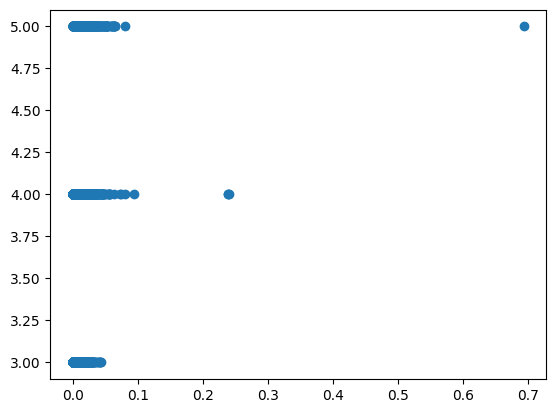

In [16]:
plt.scatter(x_full_train['pagesNumber'], y_full_train)

In [17]:
# Save the numerical features as a matrix
numerical_train_matrix = x_full_train[['Authors', 'Publisher', 'Language', 'pagesNumber']].to_numpy()
numerical_test_matrix = x_full_test[['Authors', 'Publisher', 'Language', 'pagesNumber']].to_numpy()
np.savez_compressed('./preprocessed_data/train_numerical.npz', numerical_train_matrix)
np.savez_compressed('./preprocessed_data/test_numerical.npz', numerical_test_matrix)
# print(numerical_train_matrix)

# Text Pre-processing

In [18]:
%run Text_Preprocessing.ipynb

## M1: CountVectorizer
```python
# Check
preprocess(train_df['Description'][0])

# Process data
preprocess_with_count_vectorizer('Name', train_df, test_df, ngram=1)
preprocess_with_count_vectorizer('Description', train_df, test_df, ngram=2)
preprocess_with_count_vectorizer('Name', train_df, test_df, ngram=2)
preprocess_with_count_vectorizer('Description', train_df, test_df, ngram=1)
```

## M2: doc2Vec
```python
# Check
list(tokenize_corpus(train_df['Name'], ngram=1))

# Process data
preprocess_with_doc2vec('Name', train_df, test_df, ngram=1)
preprocess_with_doc2vec('Description', train_df, test_df, ngram=2)
preprocess_with_doc2vec('Name', train_df, test_df, ngram=2)
preprocess_with_doc2vec('Description', train_df, test_df, ngram=1)
```

## M3: TfIdfVectorizer
```python
# TfidfVectorizer using the same preprocess() function as CountVectorizer
preprocess_with_tfidf_vectorizer('Name', train_df, test_df, ngram=1)
preprocess_with_tfidf_vectorizer('Description', train_df, test_df, ngram=2)
preprocess_with_tfidf_vectorizer('Name', train_df, test_df, ngram=2)
preprocess_with_tfidf_vectorizer('Description', train_df, test_df, ngram=1)
```

## Transformation

train_df: original training set, with 'Authors', 'Publisher', 'Language' encoded to numerical attributes\
test_df: original test set, with 'Authors', 'Publisher', 'Language' encoded to numerical attributes\
x_full_train: attributes in train_df\
y_train: class labels (rankings) in train_df\
x_full_test: attributes in test_df\
text_matrix: sparse matrix consisting of the 'Description' and 'Name' feature vectors\
numerical_matrix: matrix containing the (encoded) 'Authors', 'Publisher', 'Language' features\
X_train: fully transformed matrix combining text_matrix and numerical_matrix, representing the training set\
X_test: fully transformed matrix combining text_matrix and numerical_matrix, representing the training set


Dimensionality reduction: Truncated singular value decomposition (SVD)\
Unlike PCA, this estimator does not center the data before computing the SVD. This means it can work with sparse matrices efficiently.

In [19]:
from sklearn import feature_extraction
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import classification_report
from scipy import sparse
from sklearn.decomposition import TruncatedSVD, LatentDirichletAllocation
from sklearn.feature_selection import SelectKBest

In [20]:
def transform_to_matrix(name_file, description_file, numerical_file, file_type='npz', dimensionality_reduction=True):
    """
    Reads in and combines the text and numerical features into a single matrix;
    Returns the combined matrix.
    """
    
    # text features: 'Description' and 'Name'
    if file_type == 'npz':
        name_matrix = sparse.load_npz(name_file)
        description_matrix = sparse.load_npz(description_file)
        text_matrix = sparse.hstack((name_matrix, description_matrix))  # bind sparse matrices
    else:
        name_matrix = np.loadtxt(open(name_file, "rb"), delimiter=",")
        description_matrix = np.loadtxt(open(description_file, "rb"), delimiter=",")
        text_matrix = np.hstack((name_matrix, description_matrix))  # bind np arrays
    
    if dimensionality_reduction:
        # Dimensionality reduction on text features
        lda = LatentDirichletAllocation(n_components=20, random_state=30027)
        name_matrix = lda.fit_transform(name_matrix)
        text_matrix = lda.fit_transform(text_matrix)
        #svd = TruncatedSVD(n_components=10, random_state=30027)
        #name_matrix = svd.fit_transform(name_matrix)
        #text_matrix = svd.fit_transform(text_matrix)
    
    numerical_matrix = np.load(numerical_file)['arr_0']
    X = sparse.hstack((sparse.csr_matrix(numerical_matrix), text_matrix))
    
    return X

In [21]:
DESCRIPTION_TRAIN_SET = './preprocessed_data/TfIdf/train_Description_2grams_tfidf.npz'
NAME_TRAIN_SET = './preprocessed_data/TfIdf/train_Name_2grams_tfidf.npz'
NUMERICAL_TRAIN_SET = './preprocessed_data/train_numerical.npz'
FILE_TYPE = 'npz'

DESCRIPTION_TEST_SET = './preprocessed_data/TfIdf/test_Description_2grams_tfidf.npz'
NAME_TEST_SET = './preprocessed_data/TfIdf/test_Name_2grams_tfidf.npz'
NUMERICAL_TEST_SET = './preprocessed_data/test_numerical.npz'
FILE_TYPE = 'npz'

In [22]:
X_full_train = transform_to_matrix(DESCRIPTION_TRAIN_SET, NAME_TRAIN_SET, NUMERICAL_TRAIN_SET, file_type=FILE_TYPE, dimensionality_reduction=False)
#X_test = transform_to_matrix(DESCRIPTION_TEST_SET, NAME_TEST_SET, NUMERICAL_TEST_SET, file_type=FILE_TYPE)
X_full_train.shape

(23063, 165210)

In [23]:
# Split training set into training and validation set
X_train, X_val, y_train, y_val = train_test_split(X_full_train, y_full_train, train_size=0.8, random_state=30027)

In [24]:
# Feature selection
selector = SelectKBest(k=20)
selector.fit(X_train, y_train)
X_train = selector.transform(X_train)
X_val = selector.transform(X_val)
print(X_train.shape)
print(X_val.shape)

(18450, 20)
(4613, 20)


/usr/local/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0 0 0 ... 0 0 0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


In [25]:
# Check NMI of each column with the rating label
for i in range(X_train.shape[1]):
    print(f"NMI for component {i} =", normalized_mutual_info_score(X_train.toarray()[:,i], y_train))

NMI for component 0 = 0.059833786936824486
NMI for component 1 = 0.022262112423956495
NMI for component 2 = 0.00925347747733355
NMI for component 3 = 0.002837674006059229
NMI for component 4 = 0.002324573286277999
NMI for component 5 = 0.004876479809148462
NMI for component 6 = 0.005262336305333073
NMI for component 7 = 0.004223197998327533
NMI for component 8 = 0.002837674006059229
NMI for component 9 = 0.004368210086415321
NMI for component 10 = 0.0023748632224239825
NMI for component 11 = 0.004371731165282113
NMI for component 12 = 0.0041745652383561906
NMI for component 13 = 0.001860975638444911
NMI for component 14 = 0.002507766582861225
NMI for component 15 = 0.007848378002903526
NMI for component 16 = 0.002324573286277999
NMI for component 17 = 0.002324573286277999
NMI for component 18 = 0.004635143015271638
NMI for component 19 = 0.001860975638444911


/usr/local/lib/python3.9/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and multiclass values for target
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.9/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and multiclass values for target
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.9/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and multiclass values for target
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.9/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and multiclass values for target
  warnings.warn(msg, UserWarning)
/usr/local/l

In [ ]:
import seaborn
df = pd.DataFrame.sparse.from_spmatrix(X_train)
df = df.sparse.to_dense()
y_df = y_train.reset_index()
del y_df['index']

df = pd.concat([df, pd.DataFrame(y_df.values)], ignore_index = True, axis = 1)
seaborn.pairplot(df)

# Model Induction on Training set

In [ ]:
# scoring for cross validation
def report_scoring(clf, X, y, include_avg=True): 
    y_pred = clf.predict(X)
    results = classification_report(y, y_pred, output_dict=True, zero_division=0)
    
    report_dict = {}  # set up our own output dictionary
    for label in ['3.0', '4.0', '5.0']: 
        for metric in ['precision', 'recall', 'f1-score']: 
            report_dict[label + '_' + metric] = results[label][metric]
    report_dict['accuracy'] = results['accuracy']
    
    if include_avg:
        for metric in ['precision', 'recall', 'f1-score']:
            report_dict['macro_avg_' + metric] = results['macro avg'][metric]
            report_dict['weighted_avg_' + metric] = results['weighted avg'][metric]
    
    return report_dict

In [ ]:
def get_model_name(model):
    """
    Returns the name of the sklearn classifier.
    """
    return re.findall(r'(\w+)\(', str(model))[0]

In [ ]:
import time

In [30]:
def validate(clf, X, y, print_full_results=True):
    """
    Evaluates the classifier on the given dataset.
    """
    start = time.time()
    # cross validation on TRAINING set
    result = cross_validate(clf, X, y, scoring=report_scoring, cv=20)
    end = time.time()
    print(f"{get_model_name(clf)} prediction took {end - start} seconds")
    
    # Convert evaluation results to a dataframe ("test_" prefix is auto-generated)
    results_df = pd.DataFrame.from_dict(result)[['test_3.0_f1-score','test_4.0_f1-score','test_5.0_f1-score','test_accuracy']]
    if print_full_results:
        print(results_df)
    
    return results_df.mean(axis=0)

In [31]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [32]:
def evaluate(clf, X, y, print_confusion_matrix=True, print_classification_report=True):
    y_pred = clf.predict(X)
    if print_confusion_matrix:
        cm = confusion_matrix(y, y_pred)
        display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
        display.plot()
        plt.show()
    
    if print_classification_report:
        print(classification_report(y, y_pred, zero_division=0))
    
    return y_pred

In [33]:
def validate_and_test(clf, X_train, y_train, X_val, y_val, print_full_cv_results=True, print_confusion_matrix=True, print_classification_report=True):
    clf.fit(X_train, y_train)
    print("Evaluate on training set:\n")
    print(validate(clf, X_train, y_train, print_full_results=print_full_cv_results))
    print("\n\nEvaluate on validation set:\n")
    return evaluate(clf, X_val, y_val, print_confusion_matrix=print_confusion_matrix, print_classification_report=print_classification_report)

## Error Analysis

In [34]:
def get_correct_classifications(y_true, y_pred, class_label=None):
    """
    Returns a list of integers, representing the index of the correctly classified instances, 
    in the original training set (original_train_df).
    If class_label is specified, only considers the correct classification in that class.
    """
    
    y_true_copy = y_true.reset_index()  # now a dataframe with two columns, 'index' and 'rating_label'
    if class_label is None:
        match_idx = [i for i in range(len(y_pred)) if y_true_copy.iloc[i,:]['rating_label'] == y_pred[i]]
    
    else: # have a specific class label for interest
        y_true_filtered = y_true_copy[y_true_copy['rating_label'] == class_label]['rating_label']
        y_pred_filtered = pd.Series(y_pred)[y_pred == class_label]
        match_idx = y_true_filtered.index.intersection(y_pred_filtered.index).tolist()  # correct predictions
    
    original_idx = y_true_copy.iloc[match_idx,:]['index']  # index in the original training set
    return original_idx

## Hyperparameter Tuning

In [35]:
from sklearn.model_selection import GridSearchCV

In [36]:
# scoring for hyperparameter tuning
def hyperparameter_scoring(clf, X, y): 
    y_pred = clf.predict(X)
    results = classification_report(y, y_pred, output_dict=True, zero_division=0)
    
    report_dict = {}  # set up our own output dictionary
    for label in ['3.0', '4.0', '5.0']: 
        for metric in ['f1-score']: 
            report_dict[label + '_' + metric] = results[label][metric]
    report_dict['accuracy'] = results['accuracy']
    #for metric in ['precision', 'recall', 'f1-score']:
        #report_dict['weighted_avg_' + metric] = results['weighted avg'][metric]
    
    return report_dict

In [37]:
def tune_hyperparameter(clf, param_grid, X_train, y_train): 
    grid_search = GridSearchCV(clf, param_grid, scoring=hyperparameter_scoring, cv=20, verbose=2, refit=False)
    grid_search.fit(X_train, y_train)
    result_df = pd.DataFrame.from_dict(grid_search.cv_results_)
    r = re.compile('^((mean|rank)_test|params).*')
    score_metrics = list(filter(r.match, result_df.columns))
    return result_df[score_metrics]


## Naive Bayes

In [38]:
from sklearn.naive_bayes import GaussianNB

Evaluate on training set:

GaussianNB prediction took 0.1611800193786621 seconds
    test_3.0_f1-score  test_4.0_f1-score  test_5.0_f1-score  test_accuracy
0                 0.0           0.824505           0.093023       0.702059
1                 0.0           0.824729           0.048780       0.702059
2                 0.0           0.823980           0.047619       0.700975
3                 0.0           0.825255           0.095238       0.703142
4                 0.0           0.824204           0.000000       0.700975
5                 0.0           0.824505           0.093023       0.702059
6                 0.0           0.824505           0.093023       0.702059
7                 0.0           0.826837           0.222222       0.706392
8                 0.0           0.825255           0.047619       0.702059
9                 0.0           0.825782           0.139535       0.704225
10                0.0           0.824808           0.136364       0.702820
11                0

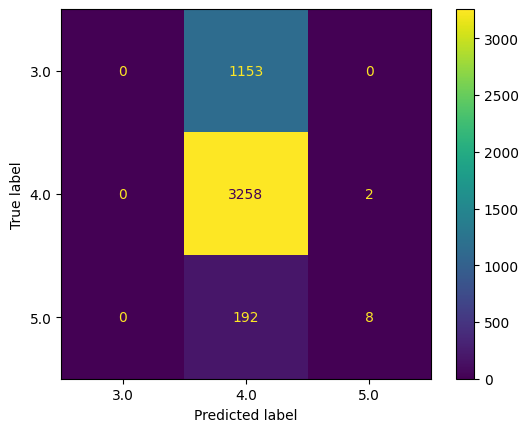

              precision    recall  f1-score   support

         3.0       0.00      0.00      0.00      1153
         4.0       0.71      1.00      0.83      3260
         5.0       0.80      0.04      0.08       200

    accuracy                           0.71      4613
   macro avg       0.50      0.35      0.30      4613
weighted avg       0.53      0.71      0.59      4613



In [39]:
gnb = GaussianNB()
y_pred = validate_and_test(gnb, X_train.toarray(), y_train, X_val.toarray(), y_val)

## Compare rating 5 instances

In [40]:
original_train_df[original_train_df['rating_label'] == 5.0]

,Name,Authors,PublishYear,PublishMonth,PublishDay,Publisher,Language,pagesNumber,Description,rating_label
18,"Sufis of Andalusia: The ""Ruh al-Quds"" & ""al-Du...",Ibn Arabi,1988,12,1,New Leaf Distributing Company,NaN,176,Sufis of Andalusia consists of biographical sk...,5.0
109,The Initiation,Donald Schnell,2003,6,13,Inner Ocean Publishing,NaN,184,An inspiring story of one man's spiritual illu...,5.0
132,Poems across the Pavement,Luis J. Rodríguez,2014,4,1,Tia Chucha,NaN,42,Tia Chucha Press started twenty-five years ago...,5.0
145,The Cambridge Encyclopedia of Human Paleopatho...,Arthur C. Aufderheide,1998,5,13,Cambridge University Press,NaN,496,The Encyclopedia of Human Paleopathology is th...,5.0
176,The Impact of God: Soundings from St John of t...,Iain Matthew,1995,9,21,Hodder & Stoughton,eng,192,St John of the Cross testifies to a God who lo...,5.0
...,...,...,...,...,...,...,...,...,...,...
22891,You Are Mine,Max Lucado,2004,5,4,Thomas Nelson,NaN,24,Max was interested in helping children underst...,5.0
22898,Town Planning in Practice,Raymond Unwin,1996,1,1,Princeton Architectural Press,NaN,456,Princeton Architectural Press's classic reprin...,5.0
22901,Étrange étranger: Une biographie de Fernando P...,Robert Bréchon,1996,10,1,Christian Bourgois,fre,619,Quel roman que cette vie où il ne se passe rie...,5.0
22945,The Heart's Desire: Satisfying the Hunger of t...,James M. Houston,2001,4,1,Regent College Publishing,NaN,272,James Houston helps us trace the consequences ...,5.0


In [41]:
original_train_df.iloc[get_correct_classifications(y_val, y_pred, class_label=5.0),:]

,Name,Authors,PublishYear,PublishMonth,PublishDay,Publisher,Language,pagesNumber,Description,rating_label
8542,Spiritual Formation Bible-NRSV,Anonymous,1999,5,1,Zondervan Publishing Company,NaN,1706,- Helps people encounter God in a more persona...,5.0
13894,Matthew Henry Study Bible-KJV,Anonymous,2006,1,15,Nelson Bibles,NaN,2333,The very best of Matthew Henry's commentary no...,5.0
3368,Holy Bible - Baptist Study Edition Celebrate Y...,W.A. Criswell,2001,5,1,NaN,NaN,2112,"The ""Holy Bible, Baptist Study Edition"" under ...",5.0
8864,Full Life Study Bible,Anonymous,1992,9,1,Zondervan Publishing Company,NaN,2225,<i>The Full Life Study Bible</i> includes a co...,5.0
11119,Mejda: The Family and Early Life of Paramahans...,Sananda Lal Ghosh,1980,12,1,Self-Realization Fellowship Publishers,NaN,328,The Family and the Early Life of Paramahansa Y...,5.0
22883,NASB Quick Study Bible: Making Bible Study Easy,Anonymous,2006,11,1,Thomas Nelson,NaN,1920,The NASB Quick Study Bible combines the New Am...,5.0
6179,Life Application Study Bible: New Living Trans...,Anonymous,2005,4,1,Tyndale House Publishers,eng,2412,"Today's #1-selling study Bible--the ""Life Appl...",5.0
11804,Iron Maiden Anthology,Iron Maiden,2006,7,1,Hal Leonard Publishing Corporation,NaN,192,(Guitar Recorded Versions). 17 hits from these...,5.0


## SVM

### Linear

In [42]:
from sklearn import svm

/usr/local/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Evaluate on training set:



/usr/local/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warning

LinearSVC prediction took 32.63809013366699 seconds
    test_3.0_f1-score  test_4.0_f1-score  test_5.0_f1-score  test_accuracy
0            0.413270           0.216000           0.000000       0.323944
1            0.314607           0.568556           0.000000       0.458288
2            0.000000           0.824729           0.048780       0.702059
3            0.000000           0.727679           0.097744       0.543879
4            0.000000           0.824204           0.000000       0.700975
5            0.404873           0.186739           0.000000       0.308776
6            0.000000           0.824204           0.000000       0.700975
7            0.000000           0.824729           0.048780       0.702059
8            0.000000           0.824729           0.000000       0.700975
9            0.000000           0.824204           0.000000       0.700975
10           0.000000           0.824729           0.000000       0.701735
11           0.000000           0.825478        

/usr/local/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


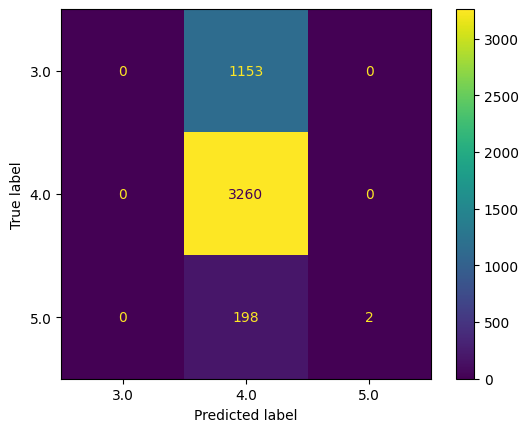

              precision    recall  f1-score   support

         3.0       0.00      0.00      0.00      1153
         4.0       0.71      1.00      0.83      3260
         5.0       1.00      0.01      0.02       200

    accuracy                           0.71      4613
   macro avg       0.57      0.34      0.28      4613
weighted avg       0.54      0.71      0.59      4613



array([4., 4., 4., ..., 4., 4., 4.])

In [43]:
linearSVM = svm.LinearSVC(random_state=30027) # set C?
linearSVM.fit(X_train, y_train)
validate_and_test(linearSVM, X_train, y_train, X_val, y_val)

Evaluate on training set:

SGDClassifier prediction took 0.41069483757019043 seconds
    test_3.0_f1-score  test_4.0_f1-score  test_5.0_f1-score  test_accuracy
0                 0.0           0.822478           0.045455       0.698808
1                 0.0           0.822023           0.083333       0.697725
2                 0.0           0.821795           0.000000       0.694475
3                 0.0           0.824808           0.000000       0.698808
4                 0.0           0.821953           0.000000       0.697725
5                 0.0           0.821725           0.000000       0.696641
6                 0.0           0.823229           0.000000       0.698808
7                 0.0           0.821201           0.000000       0.696641
8                 0.0           0.821497           0.042553       0.696641
9                 0.0           0.820218           0.000000       0.694475
10                0.0           0.823529           0.045455       0.699566
11             

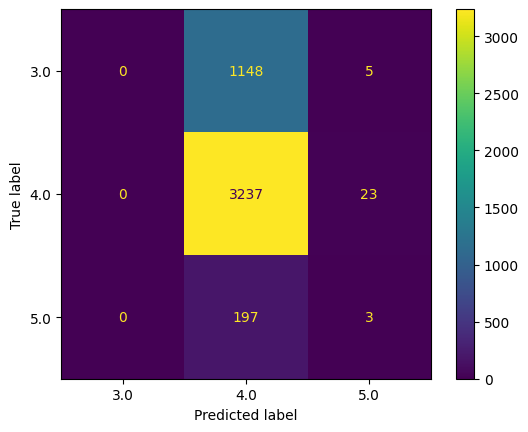

              precision    recall  f1-score   support

         3.0       0.00      0.00      0.00      1153
         4.0       0.71      0.99      0.83      3260
         5.0       0.10      0.01      0.03       200

    accuracy                           0.70      4613
   macro avg       0.27      0.34      0.28      4613
weighted avg       0.50      0.70      0.58      4613



array([4., 4., 4., ..., 4., 4., 4.])

In [44]:
# Linear SVM using Stochastic Gradient Descent
from sklearn.linear_model import SGDClassifier

# learning_rate='optimal' predicts most 4s as 3s
# validation accuracy stops increasing for eta0 < 0.0000001
svm_sgd = SGDClassifier(learning_rate='adaptive', eta0 = 0.0000001)  # default: loss='hinge' -> gives a linear SVM
validate_and_test(svm_sgd, X_train, y_train, X_val, y_val)

### Kernel SVM

In [45]:
# tune hyperparameter C
RBF_svm = svm.SVC(kernel='rbf', gamma=0.9)
param_grid = {'C': range(1, 10)}
grid_search_result = tune_hyperparameter(RBF_svm, param_grid, X_train, y_train)

Fitting 20 folds for each of 9 candidates, totalling 180 fits
[CV] END ................................................C=1; total time=   4.1s
[CV] END ................................................C=1; total time=   3.9s
[CV] END ................................................C=1; total time=   3.9s
[CV] END ................................................C=1; total time=   3.8s
[CV] END ................................................C=1; total time=   3.8s
[CV] END ................................................C=1; total time=   4.1s
[CV] END ................................................C=1; total time=   4.1s
[CV] END ................................................C=1; total time=   4.0s
[CV] END ................................................C=1; total time=   4.1s
[CV] END ................................................C=1; total time=   4.0s
[CV] END ................................................C=1; total time=   4.1s
[CV] END ......................................

[CV] END ................................................C=6; total time=   4.8s
[CV] END ................................................C=6; total time=   4.8s
[CV] END ................................................C=6; total time=   4.7s
[CV] END ................................................C=6; total time=   4.8s
[CV] END ................................................C=6; total time=   5.0s
[CV] END ................................................C=6; total time=   5.1s
[CV] END ................................................C=6; total time=   4.9s
[CV] END ................................................C=6; total time=   4.9s
[CV] END ................................................C=6; total time=   5.0s
[CV] END ................................................C=6; total time=   5.3s
[CV] END ................................................C=6; total time=   4.8s
[CV] END ................................................C=6; total time=   5.3s
[CV] END ...................

In [46]:
grid_search_result

,params,mean_test_3.0_f1-score,rank_test_3.0_f1-score,mean_test_4.0_f1-score,rank_test_4.0_f1-score,mean_test_5.0_f1-score,rank_test_5.0_f1-score,mean_test_accuracy,rank_test_accuracy
0,{'C': 1},0.205381,9,0.819219,1,0.123785,9,0.703630,1
1,{'C': 2},0.246985,8,0.810016,2,0.210562,1,0.693874,2
2,{'C': 3},0.259705,7,0.806707,9,0.208169,2,0.690081,9
3,{'C': 4},0.260123,1,0.806749,3,0.208169,2,0.690135,3
4,{'C': 5},0.260123,1,0.806749,3,0.208169,2,0.690135,3
5,{'C': 6},0.260123,1,0.806749,3,0.208169,2,0.690135,3
6,{'C': 7},0.260123,1,0.806749,3,0.208169,2,0.690135,3
7,{'C': 8},0.260123,1,0.806749,3,0.208169,2,0.690135,3
8,{'C': 9},0.260123,1,0.806749,3,0.208169,2,0.690135,3


Evaluate on training set:

SVC prediction took 80.26126480102539 seconds
    test_3.0_f1-score  test_4.0_f1-score  test_5.0_f1-score  test_accuracy
0            0.153310           0.815354           0.125000       0.694475
1            0.227586           0.826948           0.095238       0.716143
2            0.219178           0.828363           0.177778       0.716143
3            0.227425           0.825017           0.136364       0.711809
4            0.178694           0.818242           0.095238       0.700975
5            0.191781           0.820649           0.093023       0.704225
6            0.248322           0.826029           0.000000       0.713976
7            0.204778           0.821192           0.093023       0.706392
8            0.206897           0.819085           0.085106       0.704225
9            0.237500           0.814266           0.000000       0.696641
10           0.260317           0.817262           0.130435       0.704989
11           0.109091      

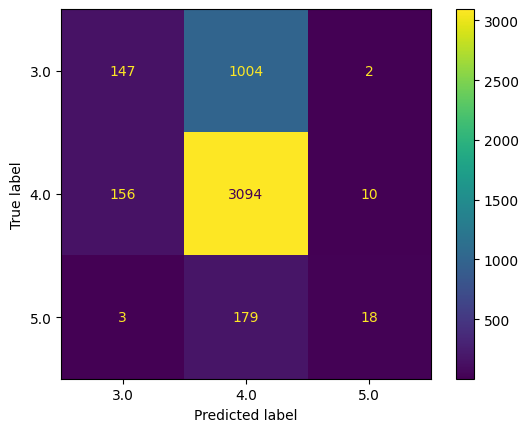

              precision    recall  f1-score   support

         3.0       0.48      0.13      0.20      1153
         4.0       0.72      0.95      0.82      3260
         5.0       0.60      0.09      0.16       200

    accuracy                           0.71      4613
   macro avg       0.60      0.39      0.39      4613
weighted avg       0.66      0.71      0.64      4613



array([4., 4., 4., ..., 4., 4., 4.])

In [47]:
# Try kernel SVM
RBF_svm = svm.SVC(kernel='rbf', gamma=0.9, C=1)
validate_and_test(RBF_svm, X_train, y_train, X_val, y_val)

## kNN

In [48]:
from sklearn.neighbors import KNeighborsClassifier

In [49]:
# tune hyperparameters p and K
knn = KNeighborsClassifier(weights = 'distance')
param_grid = {'p': [1,2], 'n_neighbors': range(1,11)}
grid_search_result = tune_hyperparameter(knn, param_grid, X_train, y_train)

Fitting 20 folds for each of 20 candidates, totalling 400 fits
[CV] END .................................n_neighbors=1, p=1; total time=   0.2s
[CV] END .................................n_neighbors=1, p=1; total time=   0.1s
[CV] END .................................n_neighbors=1, p=1; total time=   0.0s
[CV] END .................................n_neighbors=1, p=1; total time=   0.0s
[CV] END .................................n_neighbors=1, p=1; total time=   0.0s
[CV] END .................................n_neighbors=1, p=1; total time=   0.0s
[CV] END .................................n_neighbors=1, p=1; total time=   0.0s
[CV] END .................................n_neighbors=1, p=1; total time=   0.0s
[CV] END .................................n_neighbors=1, p=1; total time=   0.0s
[CV] END .................................n_neighbors=1, p=1; total time=   0.0s
[CV] END .................................n_neighbors=1, p=1; total time=   0.0s
[CV] END .................................n_ne

[CV] END .................................n_neighbors=3, p=2; total time=   0.2s
[CV] END .................................n_neighbors=3, p=2; total time=   0.2s
[CV] END .................................n_neighbors=3, p=2; total time=   0.2s
[CV] END .................................n_neighbors=3, p=2; total time=   0.2s
[CV] END .................................n_neighbors=3, p=2; total time=   0.2s
[CV] END .................................n_neighbors=3, p=2; total time=   0.2s
[CV] END .................................n_neighbors=3, p=2; total time=   0.2s
[CV] END .................................n_neighbors=3, p=2; total time=   0.2s
[CV] END .................................n_neighbors=3, p=2; total time=   0.2s
[CV] END .................................n_neighbors=3, p=2; total time=   0.2s
[CV] END .................................n_neighbors=3, p=2; total time=   0.2s
[CV] END .................................n_neighbors=3, p=2; total time=   0.2s
[CV] END ...................

[CV] END .................................n_neighbors=6, p=1; total time=   0.1s
[CV] END .................................n_neighbors=6, p=1; total time=   0.2s
[CV] END .................................n_neighbors=6, p=1; total time=   0.2s
[CV] END .................................n_neighbors=6, p=1; total time=   0.2s
[CV] END .................................n_neighbors=6, p=1; total time=   0.2s
[CV] END .................................n_neighbors=6, p=1; total time=   0.2s
[CV] END .................................n_neighbors=6, p=1; total time=   0.2s
[CV] END .................................n_neighbors=6, p=1; total time=   0.2s
[CV] END .................................n_neighbors=6, p=1; total time=   0.2s
[CV] END .................................n_neighbors=6, p=1; total time=   0.2s
[CV] END .................................n_neighbors=6, p=1; total time=   0.2s
[CV] END .................................n_neighbors=6, p=1; total time=   0.2s
[CV] END ...................

[CV] END .................................n_neighbors=8, p=2; total time=   0.2s
[CV] END .................................n_neighbors=8, p=2; total time=   0.2s
[CV] END .................................n_neighbors=8, p=2; total time=   0.2s
[CV] END .................................n_neighbors=8, p=2; total time=   0.2s
[CV] END .................................n_neighbors=8, p=2; total time=   0.2s
[CV] END .................................n_neighbors=8, p=2; total time=   0.2s
[CV] END .................................n_neighbors=8, p=2; total time=   0.2s
[CV] END .................................n_neighbors=8, p=2; total time=   0.2s
[CV] END .................................n_neighbors=8, p=2; total time=   0.2s
[CV] END .................................n_neighbors=8, p=2; total time=   0.2s
[CV] END .................................n_neighbors=8, p=2; total time=   0.2s
[CV] END .................................n_neighbors=8, p=2; total time=   0.2s
[CV] END ...................

In [50]:
grid_search_result
# p=2 (euclidean distance) is generally better
# larger k models prefers label 4.0 and hence results in higher accuracy due to data imbalance

,params,mean_test_3.0_f1-score,rank_test_3.0_f1-score,mean_test_4.0_f1-score,rank_test_4.0_f1-score,mean_test_5.0_f1-score,rank_test_5.0_f1-score,mean_test_accuracy,rank_test_accuracy
0,"{'n_neighbors': 1, 'p': 1}",0.352707,16,0.730410,18,0.229692,20,0.611055,18
1,"{'n_neighbors': 1, 'p': 2}",0.353262,15,0.730473,17,0.230455,19,0.611217,17
2,"{'n_neighbors': 2, 'p': 1}",0.373113,2,0.713871,19,0.233853,18,0.598913,19
3,"{'n_neighbors': 2, 'p': 2}",0.373638,1,0.713766,20,0.234970,17,0.598913,20
4,"{'n_neighbors': 3, 'p': 1}",0.359584,8,0.748843,15,0.243460,9,0.632355,16
5,"{'n_neighbors': 3, 'p': 2}",0.360137,5,0.748815,16,0.244116,5,0.632409,15
6,"{'n_neighbors': 4, 'p': 1}",0.363703,4,0.750586,13,0.244731,3,0.635282,14
7,"{'n_neighbors': 4, 'p': 2}",0.365344,3,0.750474,14,0.244918,2,0.635337,13
8,"{'n_neighbors': 5, 'p': 1}",0.355466,10,0.758577,11,0.245105,1,0.642492,11
9,"{'n_neighbors': 5, 'p': 2}",0.355870,9,0.758381,12,0.243895,7,0.642275,12


Evaluate on training set:

KNeighborsClassifier prediction took 4.849239110946655 seconds
    test_3.0_f1-score  test_4.0_f1-score  test_5.0_f1-score  test_accuracy
0            0.348214           0.754689           0.153846       0.634886
1            0.331183           0.740458           0.253521       0.618635
2            0.366890           0.774532           0.375000       0.661972
3            0.379592           0.746728           0.245614       0.633803
4            0.355556           0.758465           0.328358       0.644637
5            0.387097           0.764661           0.323529       0.653304
6            0.390244           0.770724           0.178571       0.659805
7            0.368889           0.760331           0.246154       0.646804
8            0.380952           0.772321           0.196721       0.659805
9            0.362851           0.757943           0.163934       0.639220
10           0.372294           0.756226           0.175439       0.642082
11        

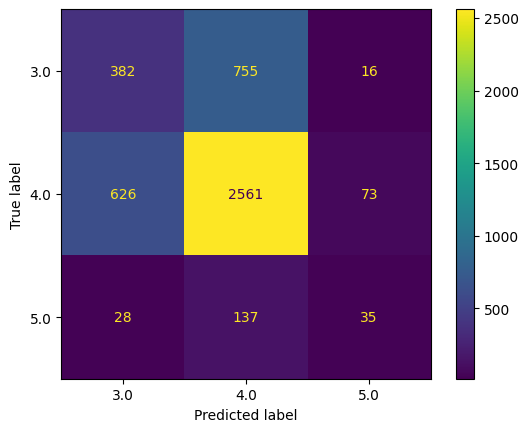

              precision    recall  f1-score   support

         3.0       0.37      0.33      0.35      1153
         4.0       0.74      0.79      0.76      3260
         5.0       0.28      0.17      0.22       200

    accuracy                           0.65      4613
   macro avg       0.46      0.43      0.44      4613
weighted avg       0.63      0.65      0.64      4613



array([3., 4., 3., ..., 4., 4., 4.])

In [51]:
knn = KNeighborsClassifier(n_neighbors=5, weights='distance')
validate_and_test(knn, X_train, y_train, X_val, y_val)

## Decision Tree

In [52]:
from sklearn.tree import DecisionTreeClassifier

In [53]:
# tune hyperparameter max_depth
dtc = DecisionTreeClassifier(random_state = 30027)
param_grid = {'max_depth': range(2,21)}
grid_search_result = tune_hyperparameter(dtc, param_grid, X_train, y_train)

Fitting 20 folds for each of 19 candidates, totalling 380 fits
[CV] END ........................................max_depth=2; total time=   0.0s
[CV] END ........................................max_depth=2; total time=   0.0s
[CV] END ........................................max_depth=2; total time=   0.0s
[CV] END ........................................max_depth=2; total time=   0.0s
[CV] END ........................................max_depth=2; total time=   0.0s
[CV] END ........................................max_depth=2; total time=   0.0s
[CV] END ........................................max_depth=2; total time=   0.0s
[CV] END ........................................max_depth=2; total time=   0.0s
[CV] END ........................................max_depth=2; total time=   0.0s
[CV] END ........................................max_depth=2; total time=   0.0s
[CV] END ........................................max_depth=2; total time=   0.0s
[CV] END .....................................

[CV] END ........................................max_depth=7; total time=   0.0s
[CV] END ........................................max_depth=7; total time=   0.0s
[CV] END ........................................max_depth=7; total time=   0.0s
[CV] END ........................................max_depth=7; total time=   0.0s
[CV] END ........................................max_depth=7; total time=   0.0s
[CV] END ........................................max_depth=7; total time=   0.0s
[CV] END ........................................max_depth=7; total time=   0.0s
[CV] END ........................................max_depth=7; total time=   0.0s
[CV] END ........................................max_depth=7; total time=   0.0s
[CV] END ........................................max_depth=7; total time=   0.0s
[CV] END ........................................max_depth=7; total time=   0.0s
[CV] END ........................................max_depth=7; total time=   0.0s
[CV] END ...................

[CV] END .......................................max_depth=12; total time=   0.1s
[CV] END .......................................max_depth=12; total time=   0.1s
[CV] END .......................................max_depth=12; total time=   0.1s
[CV] END .......................................max_depth=12; total time=   0.1s
[CV] END .......................................max_depth=12; total time=   0.1s
[CV] END .......................................max_depth=12; total time=   0.1s
[CV] END .......................................max_depth=12; total time=   0.1s
[CV] END .......................................max_depth=12; total time=   0.1s
[CV] END .......................................max_depth=12; total time=   0.1s
[CV] END .......................................max_depth=12; total time=   0.1s
[CV] END .......................................max_depth=12; total time=   0.1s
[CV] END .......................................max_depth=12; total time=   0.1s
[CV] END ...................

[CV] END .......................................max_depth=17; total time=   0.1s
[CV] END .......................................max_depth=17; total time=   0.1s
[CV] END .......................................max_depth=17; total time=   0.1s
[CV] END .......................................max_depth=17; total time=   0.1s
[CV] END .......................................max_depth=17; total time=   0.1s
[CV] END .......................................max_depth=17; total time=   0.1s
[CV] END .......................................max_depth=17; total time=   0.1s
[CV] END .......................................max_depth=17; total time=   0.1s
[CV] END .......................................max_depth=17; total time=   0.1s
[CV] END .......................................max_depth=17; total time=   0.1s
[CV] END .......................................max_depth=17; total time=   0.1s
[CV] END .......................................max_depth=17; total time=   0.1s
[CV] END ...................

In [54]:
grid_search_result
# smaller depth converge towards 0R and prefers 4.0 label

,params,mean_test_3.0_f1-score,rank_test_3.0_f1-score,mean_test_4.0_f1-score,rank_test_4.0_f1-score,mean_test_5.0_f1-score,rank_test_5.0_f1-score,mean_test_accuracy,rank_test_accuracy
0,{'max_depth': 2},0.000000,17,0.824473,4,0.102102,12,0.701843,4
1,{'max_depth': 3},0.000000,17,0.825160,1,0.036597,19,0.702602,1
2,{'max_depth': 4},0.000000,17,0.824923,3,0.086090,15,0.702440,3
3,{'max_depth': 5},0.001688,16,0.824997,2,0.064621,18,0.702548,2
4,{'max_depth': 6},0.004589,15,0.824390,5,0.072603,17,0.701735,5
5,{'max_depth': 7},0.010634,14,0.823900,6,0.079665,16,0.701247,6
6,{'max_depth': 8},0.030473,13,0.822546,7,0.098613,14,0.699946,7
7,{'max_depth': 9},0.053262,12,0.820870,8,0.101828,13,0.698320,8
8,{'max_depth': 10},0.071027,11,0.818407,9,0.106902,11,0.695340,9
9,{'max_depth': 11},0.101648,10,0.814801,10,0.118909,10,0.691545,10


Evaluate on training set:

DecisionTreeClassifier prediction took 2.1782610416412354 seconds
    test_3.0_f1-score  test_4.0_f1-score  test_5.0_f1-score  test_accuracy
0            0.257576           0.759567           0.184615       0.631636
1            0.264550           0.777224           0.095238       0.648971
2            0.287179           0.773733           0.109091       0.651138
3            0.262774           0.757267           0.101695       0.626219
4            0.254902           0.756874           0.107143       0.626219
5            0.314496           0.770575           0.121212       0.646804
6            0.186170           0.765747           0.140351       0.628386
7            0.332564           0.754269           0.212121       0.635970
8            0.225275           0.779257           0.109091       0.650054
9            0.260241           0.754967           0.111111       0.618635
10           0.303483           0.770682           0.093750       0.645336
11     

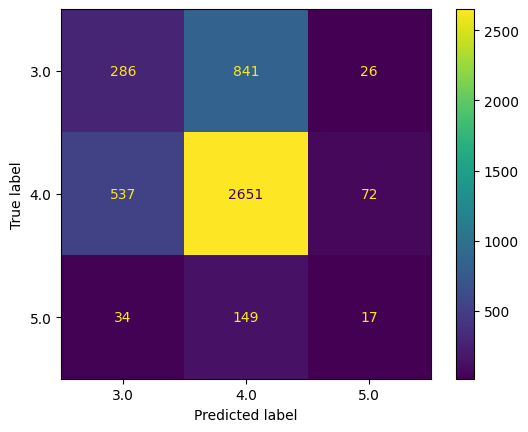

              precision    recall  f1-score   support

         3.0       0.33      0.25      0.28      1153
         4.0       0.73      0.81      0.77      3260
         5.0       0.15      0.09      0.11       200

    accuracy                           0.64      4613
   macro avg       0.40      0.38      0.39      4613
weighted avg       0.60      0.64      0.62      4613



array([4., 4., 3., ..., 4., 4., 4.])

In [55]:
dtc = DecisionTreeClassifier(max_depth=20, random_state = 30027)
validate_and_test(dtc, X_train, y_train, X_val, y_val)

## Logistic Regression

Evaluate on training set:

LogisticRegression prediction took 1.8023569583892822 seconds
    test_3.0_f1-score  test_4.0_f1-score  test_5.0_f1-score  test_accuracy
0                 0.0           0.824204           0.000000       0.700975
1                 0.0           0.824204           0.000000       0.700975
2                 0.0           0.824204           0.000000       0.700975
3                 0.0           0.824204           0.000000       0.700975
4                 0.0           0.824204           0.000000       0.700975
5                 0.0           0.824204           0.000000       0.700975
6                 0.0           0.824204           0.000000       0.700975
7                 0.0           0.824204           0.000000       0.700975
8                 0.0           0.824204           0.000000       0.700975
9                 0.0           0.825255           0.095238       0.703142
10                0.0           0.824729           0.000000       0.701735
11         

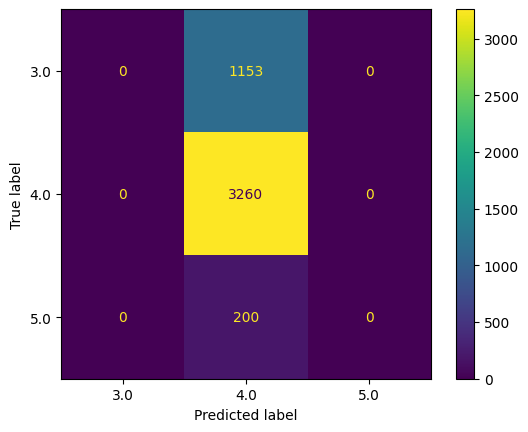

              precision    recall  f1-score   support

         3.0       0.00      0.00      0.00      1153
         4.0       0.71      1.00      0.83      3260
         5.0       0.00      0.00      0.00       200

    accuracy                           0.71      4613
   macro avg       0.24      0.33      0.28      4613
weighted avg       0.50      0.71      0.59      4613



array([4., 4., 4., ..., 4., 4., 4.])

In [56]:
from sklearn.linear_model import LogisticRegression

logr = LogisticRegression()
validate_and_test(logr, X_train, y_train, X_val, y_val)

Evaluate on training set:

SGDClassifier prediction took 0.6036229133605957 seconds
    test_3.0_f1-score  test_4.0_f1-score  test_5.0_f1-score  test_accuracy
0                 0.0           0.822478           0.045455       0.698808
1                 0.0           0.822023           0.083333       0.697725
2                 0.0           0.821795           0.000000       0.694475
3                 0.0           0.824808           0.000000       0.698808
4                 0.0           0.821953           0.000000       0.697725
5                 0.0           0.821725           0.000000       0.696641
6                 0.0           0.823229           0.000000       0.698808
7                 0.0           0.821201           0.000000       0.696641
8                 0.0           0.821497           0.042553       0.696641
9                 0.0           0.820218           0.000000       0.694475
10                0.0           0.823529           0.045455       0.699566
11              

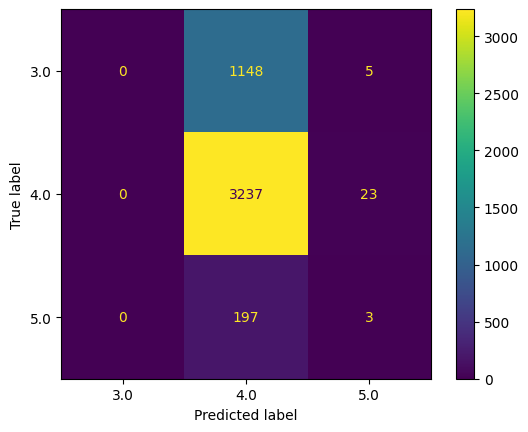

              precision    recall  f1-score   support

         3.0       0.00      0.00      0.00      1153
         4.0       0.71      0.99      0.83      3260
         5.0       0.10      0.01      0.03       200

    accuracy                           0.70      4613
   macro avg       0.27      0.34      0.28      4613
weighted avg       0.50      0.70      0.58      4613



array([4., 4., 4., ..., 4., 4., 4.])

In [57]:
# Logistic regression using Stochastic Gradient Descent
from sklearn.linear_model import SGDClassifier

# learning_rate='optimal' -> validation accuracy = 0.535
# probabilistic -> different accuracy each time
# eta0=0.0000001 -> low variance, capped at 0.698
# eta0=0.001 -> high variance, occasionally reached 0.7
logr_sgd = SGDClassifier(loss='log_loss', learning_rate='adaptive', eta0=0.0000001)
validate_and_test(logr_sgd, X_train, y_train, X_val, y_val)

## Boosting

Evaluate on training set:

AdaBoostClassifier prediction took 13.245162010192871 seconds
    test_3.0_f1-score  test_4.0_f1-score  test_5.0_f1-score  test_accuracy
0            0.000000           0.819756           0.127660       0.695558
1            0.000000           0.824729           0.048780       0.702059
2            0.000000           0.825032           0.139535       0.703142
3            0.008439           0.825782           0.095238       0.704225
4            0.000000           0.823454           0.000000       0.699892
5            0.000000           0.824505           0.093023       0.702059
6            0.000000           0.822251           0.093023       0.698808
7            0.000000           0.824808           0.181818       0.703142
8            0.000000           0.824505           0.046512       0.700975
9            0.008439           0.825782           0.095238       0.704225
10           0.008333           0.823303           0.095238       0.700651
11         

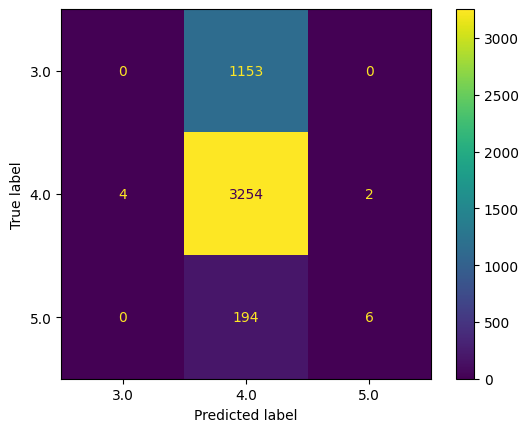

              precision    recall  f1-score   support

         3.0       0.00      0.00      0.00      1153
         4.0       0.71      1.00      0.83      3260
         5.0       0.75      0.03      0.06       200

    accuracy                           0.71      4613
   macro avg       0.49      0.34      0.30      4613
weighted avg       0.53      0.71      0.59      4613



array([4., 4., 4., ..., 4., 4., 4.])

In [62]:
from sklearn.ensemble import AdaBoostClassifier

adab = AdaBoostClassifier(n_estimators=100, random_state=30027)
validate_and_test(adab, X_train, y_train, X_val, y_val)

## Random Forest

Evaluate on training set:

RandomForestClassifier prediction took 6.136643171310425 seconds
    test_3.0_f1-score  test_4.0_f1-score  test_5.0_f1-score  test_accuracy
0                 0.0           0.824204           0.000000       0.700975
1                 0.0           0.824204           0.000000       0.700975
2                 0.0           0.824204           0.000000       0.700975
3                 0.0           0.824729           0.048780       0.702059
4                 0.0           0.824204           0.000000       0.700975
5                 0.0           0.824204           0.000000       0.700975
6                 0.0           0.824729           0.048780       0.702059
7                 0.0           0.824729           0.048780       0.702059
8                 0.0           0.824729           0.048780       0.702059
9                 0.0           0.825255           0.095238       0.703142
10                0.0           0.825782           0.097561       0.703905
11      

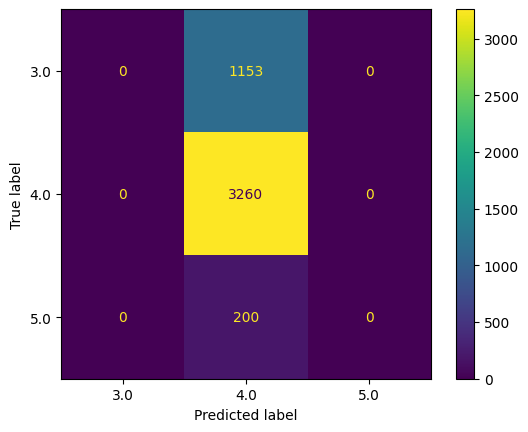

              precision    recall  f1-score   support

         3.0       0.00      0.00      0.00      1153
         4.0       0.71      1.00      0.83      3260
         5.0       0.00      0.00      0.00       200

    accuracy                           0.71      4613
   macro avg       0.24      0.33      0.28      4613
weighted avg       0.50      0.71      0.59      4613



array([4., 4., 4., ..., 4., 4., 4.])

In [63]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(max_depth=2, random_state=30027)
validate_and_test(rf, X_train, y_train, X_val, y_val)

## Combined Classifier

In [ ]:
from sklearn.ensemble import StackingClassifier

classifiers = [('linearSVM', linearSVM), ('svm_sgd', svm_sgd), ('RBF_svm', RBF_svm), ('knn', knn), ('dtc', dtc), ('logr', logr)]
sc = StackingClassifier(classifiers, verbose = 1)
validate_and_test(sc, X_train, y_train, X_val, y_val)

/usr/local/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWa

Evaluate on training set:



/usr/local/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWa

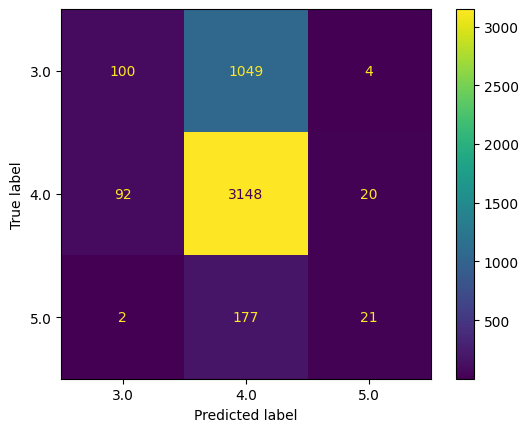

              precision    recall  f1-score   support

         3.0       0.52      0.09      0.15      1153
         4.0       0.72      0.97      0.82      3260
         5.0       0.47      0.10      0.17       200

    accuracy                           0.71      4613
   macro avg       0.57      0.39      0.38      4613
weighted avg       0.66      0.71      0.63      4613



array([4., 4., 4., ..., 4., 4., 4.])

In [59]:
evaluate(stacking_clf, X_val, y_val, print_confusion_matrix=True, print_classification_report=True)

## Baseline - 0R & 1R

In [60]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.dummy import DummyClassifier

Evaluate on training set:

DummyClassifier prediction took 0.09393882751464844 seconds
test_3.0_f1-score    0.000000
test_4.0_f1-score    0.824766
test_5.0_f1-score    0.000000
test_accuracy        0.701789
dtype: float64


Evaluate on validation set:



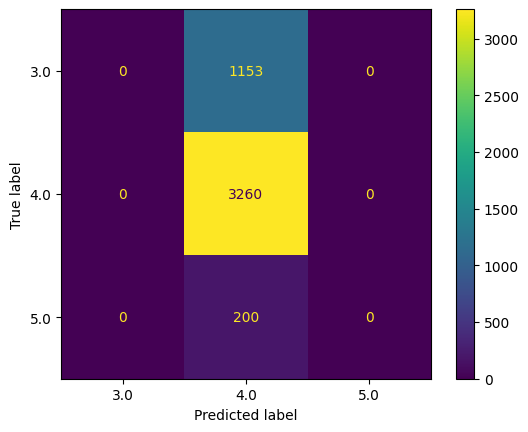

              precision    recall  f1-score   support

         3.0       0.00      0.00      0.00      1153
         4.0       0.71      1.00      0.83      3260
         5.0       0.00      0.00      0.00       200

    accuracy                           0.71      4613
   macro avg       0.24      0.33      0.28      4613
weighted avg       0.50      0.71      0.59      4613


*****************************

Evaluate on training set:

DecisionTreeClassifier prediction took 0.1644454002380371 seconds
test_3.0_f1-score    0.000000
test_4.0_f1-score    0.824766
test_5.0_f1-score    0.000000
test_accuracy        0.701789
dtype: float64


Evaluate on validation set:



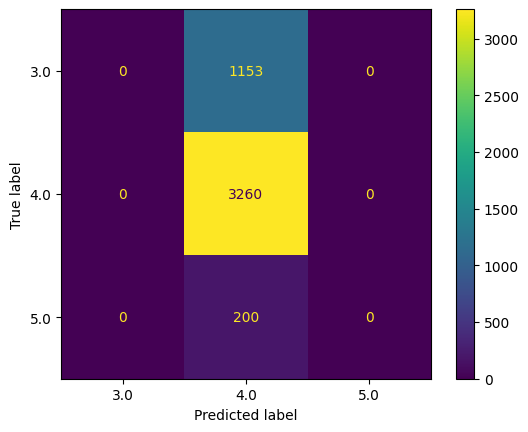

              precision    recall  f1-score   support

         3.0       0.00      0.00      0.00      1153
         4.0       0.71      1.00      0.83      3260
         5.0       0.00      0.00      0.00       200

    accuracy                           0.71      4613
   macro avg       0.24      0.33      0.28      4613
weighted avg       0.50      0.71      0.59      4613


*****************************



In [61]:
# build and test 0R and 1R model
zero_r = DummyClassifier(strategy='most_frequent')
one_r = DecisionTreeClassifier(max_depth=1)
baselines = [zero_r, one_r]

for baseline in baselines: 
    validate_and_test(baseline, X_train, y_train, X_val, y_val, print_full_cv_results=False)
    print("\n*****************************\n")